<a href="https://colab.research.google.com/github/AsifAlFaisal/multi-label-classification-pt2/blob/master/Transfer_Learning_for_Multi_Label_Classification_(Planet_Data)_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author:** ©*Asif Al Faisal*

**Email:** asif.faisal.eee@gmail.com

**Organization:** CIMMYT

### Mounting Google Drive to COLAB Disk

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/Colab Notebooks/Planet Data/'  ## My google drive location where data will be downloaded and stored from Kaggle

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Selecting TensorFlow v2.0

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


## Transfer Learning

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys, os, datetime
import numpy as np
import tensorflow as tf
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
#from tensorflow.keras.applications import ResNet152V2, InceptionV3, DenseNet201,MobileNet, VGG16,VGG19 

print(tf.__version__)

2.0.0


In [0]:
def load_dataset():
  os.chdir('/content/gdrive/My Drive/Colab Notebooks/Planet Data/train-jpg')
  data = np.load('planet_data.npz')
  X, y = data['arr_0'], data['arr_1']
  
  trainX, validX, trainY, validY = train_test_split(X, y, test_size=0.3, random_state=1)
  print(trainX.shape, trainY.shape, validX.shape, validY.shape)
  return trainX, trainY, validX, validY

## Tensorboard Experiment

In [0]:
# Load TensorBoard notebook extension
#%load_ext tensorboard
%load_ext tensorboard

In [0]:
# Clear any logs from previous runs
!rm -rf ./logs/
#tf.reset_default_graph()
#tf.compat.v1.reset_default_graph()

In [0]:
'''
def fbeta(y_true, y_pred, beta = 2):
  y_pred = backend.clip(y_pred, 0, 1)
  
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis = 1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis = 1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis = 1)
  
  # precision
  p = tp/(tp+ fp+ backend.epsilon())
  
  # recall
  r = tp/(tp+ fn+ backend.epsilon())
  
  # fbeta, averaged across each class
  
  bb = beta ** 2
  fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
  return fbeta_score
'''

# Define Model

def define_model(in_shape=(128,128,3), out_shape=17):

  ############## TRANSFER LEARNING ###################
  model = VGG19(include_top = False, input_shape = (128,128,3))
  for layer in model.layers:
    layer.trainable = False
  #model.get_layer('block5_conv1').trainable = True
  #model.get_layer('block5_conv2').trainable = True
  #model.get_layer('block5_conv3').trainable = True
  #model.get_layer('block5_pool').trainable = True


  flat1 = Flatten()(model.layers[-1].output)
  class1 = Dense(95, activation = 'relu', kernel_initializer = 'he_uniform')(flat1)
  output = Dense(17, activation = 'sigmoid')(class1)

  # define new model
  model = Model(inputs = model.inputs, outputs = output)
  #######################################################
  
  #print(model.summary())

  # compile model
  #sgd = SGD(lr = 0.1, momentum = 0.9)
  adam_mod = Adam(learning_rate=0.01,amsgrad=True)
  model.compile(optimizer = adam_mod, loss = 'binary_crossentropy')
  return model

 
  
def run_model():
  # Load Dataset
  trainX, trainY, validX, validY = load_dataset()
  
  # Create Data Generator
  #datagen = ImageDataGenerator(featurewise_center=True)
  
  # Specify imagenet mean values for centering
	
  #datagen.mean = [123.68,116.779,103.939]

  # Prepare Iterators
  #train_it = datagen.flow(trainX, trainY, batch_size=25)
  #valid_it = datagen.flow(validX, validY, batch_size=25)
  #print(len(train_it))
 
  #log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  
# Define model
  model = define_model()
  
  # simple early stopping
  #es = EarlyStopping(monitor='val_loss', min_delta=1, verbose=1, mode='min')

  # Fit model
  '''
  history = model.fit_generator(
      train_it,
      steps_per_epoch = len(train_it),
      validation_data = valid_it,
      validation_steps = len(valid_it),
      epochs = 100,
      verbose = 0,
      callbacks = [tensorboard_callback]
  )
  '''
  model.fit(trainX, trainY, epochs=15)
  model.save('amazon_vgg19.h5')
  # Evaluate model
  #loss, fbeta = model.evaluate_generator(valid_it, steps = len(valid_it), verbose = 0)
  #loss,_ = model.evaluate(validX, validY)
  #print('loss = %.3f, fbeta=%.3f' % (loss, fbeta))

  # Learning curves
  #summarize_diagnostics(history)

In [0]:
run_model()

(7284, 128, 128, 3) (7284, 17) (3122, 128, 128, 3) (3122, 17)
80142336/80134624 [==============================] - 3s 0us/step
Train on 7284 samples
Epoch 1/15
7284/7284 [==============================] - 31s 4ms/sample - loss: 0.5567
Epoch 2/15
7284/7284 [==============================] - 25s 3ms/sample - loss: 0.1532
Epoch 3/15
7284/7284 [==============================] - 25s 3ms/sample - loss: 0.1345
Epoch 4/15
7284/7284 [==============================] - 25s 3ms/sample - loss: 0.1226
Epoch 5/15
7284/7284 [==============================] - 25s 3ms/sample - loss: 0.1160
Epoch 6/15
7284/7284 [==============================] - 25s 3ms/sample - loss: 0.1081
Epoch 7/15
7284/7284 [==============================] - 25s 3ms/sample - loss: 0.1018
Epoch 8/15
7284/7284 [==============================] - 25s 3ms/sample - loss: 0.1017
Epoch 9/15
7284/7284 [==============================] - 25s 3ms/sample - loss: 0.0971
Epoch 10/15
7284/7284 [==============================] - 25s 3ms/sample - los

In [0]:
%tensorboard --logdir logs/fit

In [0]:
!kill 2506

# Final Model Export and Make Prediction (Unfinished)

In [0]:
os.getcwd()

'/content/gdrive/My Drive/Colab Notebooks/Planet Data/train-jpg'

### Make Prediction

In [0]:
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

In [0]:
def create_tag_mapping(mapping_csv):
  labels = set()
  
  for i in range(len(mapping_csv)):
    tags = mapping_csv['tags'][i].split(' ')
    
    labels.update(tags)
    
  labels = list(labels)
  labels.sort()
  
  labels_map = {labels[i]: i for i in range(len(labels))}
  inv_labels_map = {i: labels[i] for i in range(len(labels))}
  
  return labels_map, inv_labels_map

In [0]:
# convert a prediction to tags
def prediction_to_tags(inv_mapping, prediction):
  values = prediction.round()
  
  tags = [inv_mapping[i] for i in range(len(values)) if values[i] == 1.0]
  
  return tags

In [0]:
def load_image(filename):
  img = load_img(filename, target_size = (128,128))
  
  img = img_to_array(img)
  
  img = img.reshape(1, 128, 128, 3)
  
  img = img.astype('float32')
  
  img = img - [123.68, 116.779, 103.939]
  
  return img

In [0]:
def run_example(inv_mapping):
  os.chdir('/content/gdrive/My Drive/Colab Notebooks/Planet Data/test-jpg')
  img = load_image('test_2007.jpg')
  os.chdir('/content/gdrive/My Drive/Colab Notebooks/Planet Data/train-jpg')
  model = load_model('amazon_vgg19.h5')
  
  result = model.predict(img)
  
  #print(result[0])
  
  
  tags = prediction_to_tags(inv_mapping, result[0])
  print(tags)

{0: 'agriculture', 1: 'artisinal_mine', 2: 'bare_ground', 3: 'blooming', 4: 'blow_down', 5: 'clear', 6: 'cloudy', 7: 'conventional_mine', 8: 'cultivation', 9: 'habitation', 10: 'haze', 11: 'partly_cloudy', 12: 'primary', 13: 'road', 14: 'selective_logging', 15: 'slash_burn', 16: 'water'}
['agriculture', 'clear', 'primary', 'road']


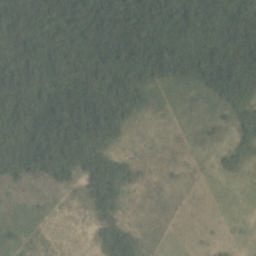

In [0]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Planet Data')
filename = 'train_v2.csv'
mapping_csv = pd.read_csv(filename)
_, inv_mapping = create_tag_mapping(mapping_csv)
print(inv_mapping)
run_example(inv_mapping)

os.chdir('/content/gdrive/My Drive/Colab Notebooks/Planet Data/test-jpg')
load_img('test_6444.jpg')


{0: 'agriculture', 1: 'artisinal_mine', 2: 'bare_ground', 3: 'blooming', 4: 'blow_down', 5: 'clear', 6: 'cloudy', 7: 'conventional_mine', 8: 'cultivation', 9: 'habitation', 10: 'haze', 11: 'partly_cloudy', 12: 'primary', 13: 'road', 14: 'selective_logging', 15: 'slash_burn', 16: 'water'}
['clear', 'primary']


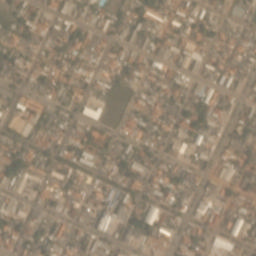

In [0]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Planet Data')
filename = 'train_v2.csv'
mapping_csv = pd.read_csv(filename)
_, inv_mapping = create_tag_mapping(mapping_csv)
print(inv_mapping)
run_example(inv_mapping)

os.chdir('/content/gdrive/My Drive/Colab Notebooks/Planet Data/test-jpg')
load_img('test_2007.jpg')